In [1]:
# misc
import os
import re
import time
import ast
import warnings
import math
import copy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns

# data
import pandas as pd
import numpy as np
import csv

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import metrics

!pip install scikit-plot
import scikitplot as skplt
import xgboost 

#### Import and Preprocess Datasets

In [2]:
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Datasets')

Mounted at /content/drive


In [3]:
headlines = pd.read_excel("Headlines_Tokenized.xlsx")
df = pd.read_csv("DatasetFull.csv", encoding = 'latin-1')
af_headlines = pd.read_csv("AdFontes Article Classifications.csv", encoding = "latin-1")
babe = pd.read_csv("final_labels_SG2.xlsx - Sheet1.csv")
df_copy = pd.read_csv("DatasetFull.csv", encoding = 'latin-1')

In [4]:
print(df["Bias"].value_counts())
print("Total dataset length:", len(df["Bias"]))

AllSides Media Bias Rating: Center             4168
AllSides Media Bias Rating: Lean Left          4029
AllSides Media Bias Rating: Lean Right         3862
AllSides Media Bias Rating: Left               2847
AllSides Media Bias Rating: Right              1635
Political News Media Bias Rating: Not Rated      26
AllSides Media Bias Rating: Mixed                17
Name: Bias, dtype: int64
Total dataset length: 16584


In [5]:
print(len(af_headlines))

5486


In [6]:
df['Label'] = df.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Left" or x == "AllSides Media Bias Rating: Right" else (0 if x == "AllSides Media Bias Rating: Center" else -99))
headlines['Label'] = headlines.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Left" or x == "AllSides Media Bias Rating: Right" else (0 if x == "AllSides Media Bias Rating: Center" else -99))
af_headlines["Label"] = af_headlines.Bias.apply(lambda x: 1 if (x > 10) | (x < -10) else (0 if (x < 5) & (x > -5) else -99))
babe['Label'] = babe.label_bias.apply(lambda x: 1 if x == "Biased" else 0)
df_copy['Label'] = df_copy.Bias.apply(lambda x: 0 if x == "AllSides Media Bias Rating: Center" else 1)

In [7]:
# resampled dataframe to contain equal number of biased and neutral observations, where biased is defined as everything that is not rated "center"
new_df = df_copy.groupby('Label').apply(lambda x: x.sample(n=4168)).reset_index(drop = True)

In [8]:
new_df['Label'].value_counts()

1    4168
0    4168
Name: Label, dtype: int64

In [9]:
df = df[df["Label"] > -50]
df = df.reset_index()
headlines = headlines[headlines["Label"] > -50]
headlines = headlines.reset_index()
af_headlines = af_headlines[af_headlines["Label"] > -50]
af_headlines = af_headlines.reset_index()

In [10]:
# cut observations with less than 25 characters

df['Cut'] = None
for index, row in df.iterrows():
    if len(df["Headline"][index]) < 25:
        df["Cut"][index] = 0
    else:
        df["Cut"][index] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# examples of unbiased headlines 
df[df['Cut'] == 0].sample(n = 5)

,index,Source,Headline,Text,Bias,Subject_Tag,Date,Label,Cut
4740,8563,The American Spectator,Predictions for 2018,"If you liked 2017, youll love 2018.",AllSides Media Bias Rating: Right,Holidays,"January 1st, 2018",1,0
6059,11144,HuffPost,Texas Toast,Facing an increasingly narrow path to the nomi...,AllSides Media Bias Rating: Left,"Presidential Elections, Elections","May 3rd, 2016",1,0
1439,2648,Rich Lowry,Mark Zuckerberg Is Right,ANALYSIS\r\nMark Zuckerberg clearly hasnt got...,AllSides Media Bias Rating: Right,"Free Speech, Civil Rights, Facebook, Social Me...","July 10th, 2020",1,0
1660,3039,American Psychological Association,COVID-19 and suicide,COVID-19 has brought a raft of intense new str...,AllSides Media Bias Rating: Center,"Science, Suicide, Coronavirus, Mental Health, ...","May 25th, 2020",0,0
5393,9735,Breitbart News,House Smashes Obamacare,House Republicans passed a revised version of ...,AllSides Media Bias Rating: Right,Healthcare,"May 4th, 2017",1,0


In [12]:
df = df[df["Cut"] == 1]
df = df.reset_index()

In [13]:
df = df.drop("level_0", axis = 1)

In [14]:
df = df.drop("Cut", axis = 1)

In [15]:
# cut headlines with less than 25 characters
af_headlines['Cut'] = None
for index, row in af_headlines.iterrows():
    if len(af_headlines["Headline"][index]) < 25:
        af_headlines["Cut"][index] = 0
    else:
        af_headlines["Cut"][index] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
af_headlines = af_headlines[af_headlines["Cut"] == 1]
af_headlines = af_headlines.reset_index()

In [17]:
af_headlines = af_headlines.drop("level_0", axis = 1)

In [18]:
af_headlines = af_headlines.drop("Cut", axis = 1)

In [19]:
df['Label'].value_counts()

1    4423
0    4153
Name: Label, dtype: int64

In [20]:
af_headlines['Label'].value_counts()

0    2497
1    1887
Name: Label, dtype: int64

In [21]:
babe['Label'].value_counts()

0    1864
1    1810
Name: Label, dtype: int64

In [22]:
new_df['Label'].value_counts()

1    4168
0    4168
Name: Label, dtype: int64

In [23]:
x = df.drop(['Label', 'Bias'], 1)
y = df[['Label']]

In [24]:
x_b = babe[['text']]
y_b = babe[['Label']]

In [25]:
# train-test split
train_features, test_features, train_labels, test_labels = train_test_split(x, y,
                                                                                                             test_size = 0.10, random_state = 42)
train_features1, val_features, train_labels1, val_labels = train_test_split(train_features, train_labels,
                                                                                                             test_size = 0.10, random_state = 42)

In [26]:
# lets see a couple examples to use in our section on politcal bias vs media bias
import random
bias_babe = babe[babe["Label"] == 1]
bias_babe.reset_index(inplace = True)
bias_df = df[df["Label"] == 1]
bias_df.reset_index(inplace = True)
bias_af = af_headlines[af_headlines['Label'] == 1]
bias_af.reset_index(inplace = True)
random.seed(1014)
ran_babe = random.randint(0, len(bias_babe))
ran_af = random.randint(0, len(bias_af))
print(bias_babe["text"].iloc[ran_babe])
print(bias_af["Headline"].iloc[ran_af])
print("--------------------------------")
ran_babe = random.randint(0, len(bias_babe))
ran_af = random.randint(0, len(bias_af))
print(bias_babe["text"].iloc[ran_babe])
print(bias_af["Headline"].iloc[ran_af])
print("--------------------------------")
ran_babe = random.randint(0, len(bias_babe))
ran_af = random.randint(0, len(bias_af))
print(bias_babe["text"].iloc[ran_babe])
print(bias_af["Headline"].iloc[ran_af])


President of Belarus refuses to cancel sports and scoffs at ‘Psychosis’ of coronavirus measures.
Bigot, Alleged Pedophile Roy Moore Tops GOP Senate Field in Poll
--------------------------------
For one thing, Trump’s impatience now threatens to undo the measures of the last ten weeks. Thanks in part to the foment of anti-lockdown protesters tacitly endorsed by Trump, governors are under increasing political pressure to reopen quickly—perhaps too soon.
Media Fail to Identify Xenophobia as Biden Says Trump Rolled Over for Chinese
--------------------------------
After Donald Trump’s outrageous photo op in which he used federal police to attack peaceful protesters so that he could walk to a church to hold up a Bible, others noted how inappropriate it was for General Mark Milley, the current chairman of the Joint Chiefs of Staff, to not only be tailing behind Donald Trump during this publicized stunt but to be wearing his battle fatigues, something extremely inappropriate for the settin

## Classification

In [27]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 51.0 MB/s 
     |████████████████████████████████| 636 kB 57.9 MB/s 
     |████████████████████████████████| 3.3 MB 54.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [28]:
import sys
import os
import time
import re
import random
from typing import Dict, List, Optional, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import LongformerTokenizer, TFLongformerForSequenceClassification
from transformers import T5Tokenizer, T5Model
from transformers import GPT2Tokenizer, GPT2Model

In [29]:
# set seed, TF uses python ramdom and numpy library, so these must also be fixed
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
os.environ['PYTHONHASHSEED']=str(0)
os.environ['TF_DETERMINISTIC_OPS'] = '0'

In [30]:
# see if hardware accelerator available
tf.config.experimental.list_physical_devices() 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [32]:
# Stratified k-Fold instance
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
# helper functions called in skfold loop

def pd_to_tf(df):
    """convert a pandas dataframe into a tensorflow dataset"""
    target = df.pop('Label')
    headline = df.pop('Headline')
    return tf.data.Dataset.from_tensor_slices((headline.values, target.values))

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

def tokenize(df):
    """convert a pandas dataframe into a tensorflow dataset and run hugging face's tokenizer on data"""
    target = df.pop('Label')
    headline = df.pop('Headline')

    train_encodings = tokenizer(
                        headline.tolist(),                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        truncation = True, # cut off at max length of the text that can go to BERT
                        padding = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
    
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings), 
         target.tolist()))
    return dataset

In [34]:
def run_model_5fold(df_train, model_name, freeze_encoder=True, pretrained=False, plot=False):
    """"freeze flags whether encoder layer should be frozen to not destroy transfer learning. Only set to false when enough data is provided"""

    # these variables will be needed for skfold to select indices
    Y = df_train['Label']
    X = df_train['Headline']

    # hyperparams
    BUFFER_SIZE = 10000
    BATCH_SIZE = 32
    k = 1

    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    val_f1_micro = []
    val_f1_wmacro = []

    for train_index, val_index in skfold.split(X,Y):
        print('### Start fold {}'.format(k))

        # split into train and validation set
        train_dataset = df_train.iloc[train_index]
        val_dataset = df_train.iloc[val_index]

        # prepare data for transformer
        train_dataset = tokenize(train_dataset)
        val_dataset = tokenize(val_dataset)

        # mini-batch it
        train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

        # create new model
        if model_name == 'bert':
            model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
        if model_name == 'distilbert':
            model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
        elif model_name == 'roberta':
            model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')
        elif model_name == 'electra':
            model = TFElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator')
        elif model_name == 'xlnet':
            model = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased')
        elif model_name == 't5':
            model = T5Model.from_pretrained('t5-base')
        elif model_name == 'gpt':
            model = GPT2ForSequenceClassification.from_pretrained('microsoft/DialogRPT-updown')
            


        if freeze_encoder == True:
            for w in model.get_layer(index=0).weights:
                w._trainable = False

        # compile it
        optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5) 
        model.compile(optimizer=optimizer, loss=model.compute_loss) 

        # transfer learning
        if pretrained == True:
            model.get_layer(index=0).set_weights(trained_model_layer) # load bias-specific weights
            #model.load_weights('./checkpoints/')

        # after 2 epochs without improvement, stop training
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

        # fit it
        history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, callbacks=[callback])

        # plot history
        if plot:
            plot_graphs(history,'loss')

        # evaluate
        loss = model.evaluate(val_dataset)

        if model_name == 'xlnet':
            yhats = []
            for row in df_train.iloc[val_index]['Headline']:
                input = tokenizer(row, return_tensors="tf")
                output = model(input)
                logits = output.logits.numpy()[0]
                candidates = logits.tolist()
                decision = candidates.index(max(candidates))
                yhats.append(decision)
        else:
            logits = model.predict(val_dataset)  
            yhats = []
            for i in logits[0]:
                # assign class label according to highest logit
                candidates = i.tolist()
                decision = candidates.index(max(candidates))
                yhats.append(decision)

        y = []
        for text, label in val_dataset.unbatch():   
              y.append(label.numpy())

        val_loss.append(loss)
        val_acc.append(accuracy_score(y, yhats))
        val_prec.append(precision_score(y, yhats))
        val_rec.append(recall_score(y, yhats))
        val_f1.append(f1_score(y, yhats))
        val_f1_micro.append(f1_score(y, yhats, average='micro'))
        val_f1_wmacro.append(f1_score(y, yhats, average='weighted'))

        tf.keras.backend.clear_session()

        k += 1

        

    return val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro

### AllSides

#### BERT

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df, model_name='bert', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Start fold 1


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 62s 227ms/step - loss: 0.6733 - val_loss: 0.6672
Epoch 2/10
215/215 [==============================] - 46s 216ms/step - loss: 0.5845 - val_loss: 0.6518
Epoch 3/10
54/54 [==============================] - 4s 78ms/step - loss: 0.6518
### Start fold 3


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 65s 233ms/step - loss: 0.6801 - val_loss: 0.6608
Epoch 2/10
215/215 [==============================] - 47s 221ms/step - loss: 0.6121 - val_loss: 0.6297
Epoch 3/10
54/54 [==============================] - 4s 76ms/step - loss: 0.6297
### Start fold 4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 64s 231ms/step - loss: 0.6763 - val_loss: 0.6688
Epoch 2/10
54/54 [==============================] - 4s 70ms/step - loss: 0.6688
### Start fold 5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 64s 230ms/step - loss: 0.6730 - val_loss: 0.6359
Epoch 2/10
54/54 [==============================] - 4s 67ms/step - loss: 0.6359
5-Fold CV Loss: 0.645477831363678
5-Fold CV Accuracy: 0.6251167200146792
5-Fold CV Precision: 0.6491809066027606
5-Fold CV Recall: 0.6215791088273641
5-Fold CV F1 Score: 0.6214284571335817
5-Fold CV Micro F1 Score: 0.6251167200146792
5-Fold CV Weighted Macro F1 Score: 0.6166829298058032


#### DistilBERT

In [36]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df, model_name='distilbert', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

### Start fold 1


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
215/215 [==============================] - 35s 122ms/step - loss: 0.6616 - val_loss: 0.6348
Epoch 2/10
54/54 [==============================] - 2s 39ms/step - loss: 0.6348
### Start fold 2


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
215/215 [==============================] - 32s 118ms/step - loss: 0.6534 - val_loss: 0.6542
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.6542
### Start fold 3


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
215/215 [==============================] - 33s 121ms/step - loss: 0.6667 - val_loss: 0.6484
Epoch 2/10
215/215 [==============================] - 25s 114ms/step - loss: 0.5738 - val_loss: 0.6365
Epoch 3/10
54/54 [==============================] - 2s 38ms/step - loss: 0.6365
### Start fold 4


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
215/215 [==============================] - 33s 120ms/step - loss: 0.6636 - val_loss: 0.6460
Epoch 2/10
54/54 [==============================] - 2s 35ms/step - loss: 0.6460
### Start fold 5


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
215/215 [==============================] - 33s 120ms/step - loss: 0.6648 - val_loss: 0.6262
Epoch 2/10
54/54 [==============================] - 2s 34ms/step - loss: 0.6262
5-Fold CV Loss: 0.6395406246185302
5-Fold CV Accuracy: 0.6364266345898999
5-Fold CV Precision: 0.6418816978212224
5-Fold CV Recall: 0.6945632333767928
5-Fold CV F1 Score: 0.6623625628989562
5-Fold CV Micro F1 Score: 0.6364266345898999
5-Fold CV Weighted Macro F1 Score: 0.6314755851399975


#### RoBERTa

In [37]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df, model_name='roberta', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

### Start fold 1


Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 77s 283ms/step - loss: 0.6670 - val_loss: 0.6415
Epoch 2/10
54/54 [==============================] - 4s 79ms/step - loss: 0.6415
### Start fold 2


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 74s 280ms/step - loss: 0.6646 - val_loss: 0.6417
Epoch 2/10
215/215 [==============================] - 58s 270ms/step - loss: 0.6136 - val_loss: 0.6381
Epoch 3/10
54/54 [==============================] - 4s 71ms/step - loss: 0.6381
### Start fold 3


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 67s 248ms/step - loss: 0.6609 - val_loss: 0.6161
Epoch 2/10
54/54 [==============================] - 5s 92ms/step - loss: 0.6161
### Start fold 4


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 75s 281ms/step - loss: 0.6627 - val_loss: 0.6334
Epoch 2/10
215/215 [==============================] - 58s 270ms/step - loss: 0.6150 - val_loss: 0.6005
Epoch 3/10
54/54 [==============================] - 4s 73ms/step - loss: 0.6005
### Start fold 5


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 75s 282ms/step - loss: 0.6689 - val_loss: 0.6244
Epoch 2/10
215/215 [==============================] - 58s 271ms/step - loss: 0.6079 - val_loss: 0.5871
Epoch 3/10
54/54 [==============================] - 4s 77ms/step - loss: 0.5871
5-Fold CV Loss: 0.6166400074958801
5-Fold CV Accuracy: 0.6646483448524265
5-Fold CV Precision: 0.6598610045496089
5-Fold CV Recall: 0.7318710535061482
5-Fold CV F1 Score: 0.6919540267604727
5-Fold CV Micro F1 Score: 0.6646483448524265
5-Fold CV Weighted Macro F1 Score: 0.661505333997616


#### Electra

In [38]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df, model_name='electra', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

### Start fold 1


Downloading:   0%|          | 0.00/54.5M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 34s 79ms/step - loss: 0.6711 - val_loss: 0.6491
Epoch 2/10
215/215 [==============================] - 15s 68ms/step - loss: 0.6200 - val_loss: 0.6444
Epoch 3/10
54/54 [==============================] - 2s 29ms/step - loss: 0.6444
### Start fold 2


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 31s 81ms/step - loss: 0.6737 - val_loss: 0.6624
Epoch 2/10
215/215 [==============================] - 14s 67ms/step - loss: 0.6240 - val_loss: 0.6566
Epoch 3/10
54/54 [==============================] - 2s 30ms/step - loss: 0.6566
### Start fold 3


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 32s 81ms/step - loss: 0.6729 - val_loss: 0.6438
Epoch 2/10
215/215 [==============================] - 15s 68ms/step - loss: 0.6207 - val_loss: 0.6340
Epoch 3/10
54/54 [==============================] - 2s 29ms/step - loss: 0.6340
### Start fold 4


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 31s 79ms/step - loss: 0.6706 - val_loss: 0.6590
Epoch 2/10
215/215 [==============================] - 15s 68ms/step - loss: 0.6262 - val_loss: 0.6444
Epoch 3/10
54/54 [==============================] - 1s 28ms/step - loss: 0.6444
### Start fold 5


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 32s 79ms/step - loss: 0.6734 - val_loss: 0.6566
Epoch 2/10
215/215 [==============================] - 15s 68ms/step - loss: 0.6229 - val_loss: 0.6470
Epoch 3/10
54/54 [==============================] - 1s 27ms/step - loss: 0.6470
5-Fold CV Loss: 0.6452997326850891
5-Fold CV Accuracy: 0.6349113471562451
5-Fold CV Precision: 0.6342297316336576
5-Fold CV Recall: 0.7012971342383107
5-Fold CV F1 Score: 0.6621588943869681
5-Fold CV Micro F1 Score: 0.6349113471562451
5-Fold CV Weighted Macro F1 Score: 0.6300258000409714


#### XLNET

In [39]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df, model_name='xlnet', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Start fold 1


Downloading:   0%|          | 0.00/565M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 82s 299ms/step - loss: 0.6859 - val_loss: 0.6472
Epoch 2/10
215/215 [==============================] - 62s 289ms/step - loss: 0.6430 - val_loss: 0.6434
Epoch 3/10
54/54 [==============================] - 5s 93ms/step - loss: 0.6434
### Start fold 2


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 77s 298ms/step - loss: 0.6804 - val_loss: 0.6554
Epoch 2/10
54/54 [==============================] - 5s 91ms/step - loss: 0.6554
### Start fold 3


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 77s 296ms/step - loss: 0.6713 - val_loss: 0.6675
Epoch 2/10
215/215 [==============================] - 61s 286ms/step - loss: 0.6264 - val_loss: 0.6208
Epoch 3/10
54/54 [==============================] - 4s 81ms/step - loss: 0.6208
### Start fold 4


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 78s 299ms/step - loss: 0.7016 - val_loss: 0.6945
Epoch 2/10
215/215 [==============================] - 62s 287ms/step - loss: 0.6958 - val_loss: 0.6712
Epoch 3/10
215/215 [==============================] - 62s 287ms/step - loss: 0.6627 - val_loss: 0.6477
Epoch 4/10
215/215 [==============================] - 62s 287ms/step - loss: 0.6161 - val_loss: 0.6201
Epoch 5/10
54/54 [==============================] - 5s 93ms/step - loss: 0.6201
### Start fold 5


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
215/215 [==============================] - 78s 299ms/step - loss: 0.6781 - val_loss: 0.6460
Epoch 2/10
215/215 [==============================] - 62s 288ms/step - loss: 0.6245 - val_loss: 0.6011
Epoch 3/10
54/54 [==============================] - 5s 93ms/step - loss: 0.6011
5-Fold CV Loss: 0.6281654596328735
5-Fold CV Accuracy: 0.6584648005056167
5-Fold CV Precision: 0.6593260262719272
5-Fold CV Recall: 0.7232983101976123
5-Fold CV F1 Score: 0.683841833499995
5-Fold CV Micro F1 Score: 0.6584648005056167
5-Fold CV Weighted Macro F1 Score: 0.6529466145517556


### LDA Topic Modelling for Dataset Comparison

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
lemmatizer = nltk.stem.WordNetLemmatizer()
 
 
stop_words = set(stopwords.words('english'))
 
df["word_tokens"] = df.Headline.apply(word_tokenize)
 

 

filtered_list = []
 
for i in df["word_tokens"]:
  filtered_sentence = []
  for w in i:
      if w not in stop_words:
          w = lemmatizer.lemmatize(w)
          filtered_sentence.append(w)
  filtered_list.append(filtered_sentence)
df["lda_ready"] = filtered_list
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,index,Source,Headline,Text,Bias,Subject_Tag,Date,Label,word_tokens,lda_ready
0,1,Wall Street Journal (News),Vaccines Appear to Be Slowing Spread of Covid-...,Vaccines appear to be starting to curb new Cov...,AllSides Media Bias Rating: Center,"Coronavirus, Coronavirus Vaccine, Coronavirus ...","May 3rd, 2021",0,"[Vaccines, Appear, to, Be, Slowing, Spread, of...","[Vaccines, Appear, Be, Slowing, Spread, Covid-..."
1,4,The Hill,"New York Times, WaPo, NBC retract reports abou...","The New York Times, The Washington Post and NB...",AllSides Media Bias Rating: Center,"Media Industry, Media Bias, New York Times, Wa...","May 2nd, 2021",0,"[New, York, Times, ,, WaPo, ,, NBC, retract, r...","[New, York, Times, ,, WaPo, ,, NBC, retract, r..."
2,5,CNN (Online News),"Washington Post, New York Times, and NBC News ...","The Washington Post, The New York Times, and N...",AllSides Media Bias Rating: Left,"Media Industry, Media Bias, New York Times, Wa...","May 2nd, 2021",1,"[Washington, Post, ,, New, York, Times, ,, and...","[Washington, Post, ,, New, York, Times, ,, NBC..."
3,8,The Hill,Biden cancels military-funded border wall proj...,President Biden is canceling projects to build...,AllSides Media Bias Rating: Center,"Immigration, Border Wall, Pentagon, US Militar...","May 1st, 2021",0,"[Biden, cancels, military-funded, border, wall...","[Biden, cancel, military-funded, border, wall,..."
4,10,Ezra Klein,"100 Days of Big, Bold, Partisan Change",OPINION\r\nI intended to duly fulfill my duty ...,AllSides Media Bias Rating: Left,"Bridging Divides, Joe Biden, Polarization, Whi...","April 30th, 2021",1,"[100, Days, of, Big, ,, Bold, ,, Partisan, Cha...","[100, Days, Big, ,, Bold, ,, Partisan, Change]"
...,...,...,...,...,...,...,...,...,...,...
8571,16575,Townhall,CNN Takes Almost 3 Hours to Report Family Rese...,Mary Katharine Ham provides the details:\r\nCo...,AllSides Media Bias Rating: Right,Violence In America,"August 16th, 2012",1,"[CNN, Takes, Almost, 3, Hours, to, Report, Fam...","[CNN, Takes, Almost, 3, Hours, Report, Family,..."
8572,16576,CNN (Online News),"DC shooting suspect: ""I don't like your politi...",The suspect in the shooting at the Family Rese...,AllSides Media Bias Rating: Left,Violence In America,"August 16th, 2012",1,"[DC, shooting, suspect, :, ``, I, do, n't, lik...","[DC, shooting, suspect, :, ``, I, n't, like, p..."
8573,16578,CNN (Online News),Program providing protection for young immigra...,(CNN) -- Hundreds of thousands of people who e...,AllSides Media Bias Rating: Left,"Presidential Elections, Elections","August 15th, 2012",1,"[Program, providing, protection, for, young, i...","[Program, providing, protection, young, immigr..."
8574,16582,CNN (Online News),Romney campaign tries to take Medicare away fr...,Washington (CNN) -- The fight to define Paul R...,AllSides Media Bias Rating: Left,Healthcare,"August 15th, 2012",1,"[Romney, campaign, tries, to, take, Medicare, ...","[Romney, campaign, try, take, Medicare, away, ..."


In [43]:
doc_sample = df[["Headline"]].iloc[202].values[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(df[["lda_ready"]].iloc[202].values[0])

original document: 
['AstraZeneca:', 'US', 'data', 'shows', 'vaccine', 'effective', 'for', 'all', 'adults']


 tokenized and lemmatized document: 
['AstraZeneca', ':', 'US', 'data', 'show', 'vaccine', 'effective', 'adult']


In [44]:
processed_docs = df["lda_ready"]
processed_docs[:10]

0    [Vaccines, Appear, Be, Slowing, Spread, Covid-...
1    [New, York, Times, ,, WaPo, ,, NBC, retract, r...
2    [Washington, Post, ,, New, York, Times, ,, NBC...
3    [Biden, cancel, military-funded, border, wall,...
4       [100, Days, Big, ,, Bold, ,, Partisan, Change]
5                              [Bidens, Con, America]
6    [The, global, chip, shortage, going, bad, wors...
7             [Why, care, semiconductor, chip, crisis]
8    [Mark, Kelly, :, I, n't, hear, plan, border, B...
9    [Biden, 's, 1st, 100, Days, :, A, Look, By, Th...
Name: lda_ready, dtype: object

In [46]:
import gensim

In [47]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 Appear
1 Be
2 Covid-19
3 Infections
4 Slowing
5 Spread
6 Vaccines
7 's
8 ,
9 FBI
10 Giuliani


In [48]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [49]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(113, 1), (196, 1), (323, 1), (385, 1), (788, 1)]

In [50]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 113 ("Trump") appears 1 time.
Word 196 ("President") appears 1 time.
Word 323 ("fight") appears 1 time.
Word 385 ("election") appears 1 time.
Word 788 ("abortion") appears 1 time.


In [51]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [52]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.080*"'s" + 0.040*"Obama" + 0.040*":" + 0.025*"House" + 0.020*"?" + 0.015*"Romney" + 0.014*"'" + 0.013*"White" + 0.013*"Trump" + 0.013*"GOP"
Topic: 1 
Words: 0.091*":" + 0.040*"'s" + 0.026*"," + 0.025*"Trump" + 0.024*"'" + 0.018*"Obama" + 0.016*"Romney" + 0.016*"In" + 0.016*"House" + 0.013*"Court"
Topic: 2 
Words: 0.064*"'" + 0.038*":" + 0.027*"Trump" + 0.023*"Obama" + 0.023*"To" + 0.018*"say" + 0.016*"," + 0.013*"campaign" + 0.013*"Republicans" + 0.012*"'s"
Topic: 3 
Words: 0.026*":" + 0.026*"Obama" + 0.024*"Korea" + 0.024*"?" + 0.024*"To" + 0.023*"," + 0.022*"'" + 0.021*"North" + 0.019*"'s" + 0.019*"GOP"
Topic: 4 
Words: 0.063*":" + 0.043*"," + 0.030*"The" + 0.029*"'" + 0.021*"Obama" + 0.020*"On" + 0.017*"To" + 0.016*"Senate" + 0.014*"?" + 0.013*"Is"
Topic: 5 
Words: 0.057*"," + 0.039*":" + 0.038*"Trump" + 0.036*"Romney" + 0.031*"Obama" + 0.028*"'s" + 0.020*"For" + 0.017*"The" + 0.016*"To" + 0.012*"Of"
Topic: 6 
Words: 0.064*"Obama" + 0.059*"," + 0.023*"'" + 0.023*"

In [53]:
babe.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,Label
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[],0
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",1
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[],1
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult'],1


In [54]:
stop_words = set(stopwords.words('english'))
 
babe["word_tokens"] = babe.text.apply(word_tokenize)
 

 

filtered_list = []
 
for i in babe["word_tokens"]:
  filtered_sentence = []
  for w in i:
      if w not in stop_words:
          w = lemmatizer.lemmatize(w)
          filtered_sentence.append(w)
  filtered_list.append(filtered_sentence)
babe["lda_ready"] = filtered_list
babe

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,Label,word_tokens,lda_ready
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[],0,"[``, Orange, Is, the, New, Black, '', star, Ya...","[``, Orange, Is, New, Black, '', star, Yael, S..."
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1,"[``, We, have, one, beautiful, law, ,, '', Tru...","[``, We, one, beautiful, law, ,, '', Trump, re..."
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",1,"[..., immigrants, as, criminals, and, eugenics...","[..., immigrant, criminal, eugenics, ,, consid..."
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[],1,"[..., we, sounded, the, alarm, in, the, early,...","[..., sounded, alarm, early, month, Trump, ’, ..."
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult'],1,"[[, Black, Lives, Matter, ], is, essentially, ...","[[, Black, Lives, Matter, ], essentially, non-..."
...,...,...,...,...,...,...,...,...,...,...,...
3669,You’ve heard of Jim Crow and Southern Segregat...,http://feedproxy.google.com/~r/breitbart/~3/ei...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['ALL'],1,"[You, ’, ve, heard, of, Jim, Crow, and, Southe...","[You, ’, heard, Jim, Crow, Southern, Segregati..."
3670,Young female athletes’ dreams and accomplishme...,http://feedproxy.google.com/~r/breitbart/~3/eW...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,"['dashed', '""identify""']",1,"[Young, female, athletes, ’, dreams, and, acco...","[Young, female, athlete, ’, dream, accomplishm..."
3671,"Young white men, reacting to social and educat...",https://thefederalist.com/2016/05/23/how-anti-...,Federalist,white-nationalism,right,Biased,Expresses writer’s opinion,"['evil', 'white']",1,"[Young, white, men, ,, reacting, to, social, a...","[Young, white, men, ,, reacting, social, educa..."
3672,Young women taking part in high school and col...,NaN,Breitbart,sport,right,Biased,Somewhat factual but also opinionated,"['dashed', '""identify""']",1,"[Young, women, taking, part, in, high, school,...","[Young, woman, taking, part, high, school, col..."


In [55]:
doc_sample = babe[["text"]].iloc[202].values[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(babe[["lda_ready"]].iloc[202].values[0])

original document: 
['After', 'the', 'first', 'Black', 'president,', 'Barack', 'Obama,', 'was', 'elected', 'in', '2008,', 'the', 'number', 'of', 'hate', 'groups', '“ballooned,”', 'Miller-Idriss', 'said,', 'just', 'as', 'Ku', 'Klux', 'Klan', 'activity', 'grew', 'again', 'after', 'the', '1954', 'Brown', 'v.', 'Board', 'of', 'Ed.', 'decision', 'desegregating', 'schools,', 'and', 'during', 'the', '1960s', 'civil', 'rights', 'movement.']


 tokenized and lemmatized document: 
['After', 'first', 'Black', 'president', ',', 'Barack', 'Obama', ',', 'elected', '2008', ',', 'number', 'hate', 'group', '“', 'ballooned', ',', '”', 'Miller-Idriss', 'said', ',', 'Ku', 'Klux', 'Klan', 'activity', 'grew', '1954', 'Brown', 'v.', 'Board', 'Ed', '.', 'decision', 'desegregating', 'school', ',', '1960s', 'civil', 'right', 'movement', '.']


In [56]:
processed_docs = babe["lda_ready"]
processed_docs[:10]

0    [``, Orange, Is, New, Black, '', star, Yael, S...
1    [``, We, one, beautiful, law, ,, '', Trump, re...
2    [..., immigrant, criminal, eugenics, ,, consid...
3    [..., sounded, alarm, early, month, Trump, ’, ...
4    [[, Black, Lives, Matter, ], essentially, non-...
5    [[, Democrats, employ, ], full, arsenal, deleg...
6    [[, Newsoms, 's, ], obsession, mask, created, ...
7    [[, Newsoms, 's, ], onslaught, propaganda, ign...
8    [[, The, police, ], prefer, think, like, glori...
9    [‘, A, new, low, ’, :, Washington, Post, mediu...
Name: lda_ready, dtype: object

In [57]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 ''
1 .
2 Australia
3 Black
4 Is
5 New
6 Orange
7 Stone
8 U.S.
9 Yael
10 ``


In [58]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [59]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[202]

[(1, 1),
 (16, 1),
 (41, 1),
 (42, 1),
 (92, 1),
 (97, 1),
 (172, 1),
 (182, 1),
 (255, 1),
 (260, 1),
 (275, 1),
 (485, 1),
 (486, 1),
 (519, 1),
 (574, 1),
 (668, 1),
 (674, 1),
 (716, 1)]

In [60]:
bow_doc_202 = bow_corpus[202]
for i in range(len(bow_doc_202)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_202[i][0], 
                                               dictionary[bow_doc_202[i][0]], 
bow_doc_202[i][1]))

Word 1 ("Black") appears 1 time.
Word 16 ("said") appears 1 time.
Word 41 ("“") appears 1 time.
Word 42 ("”") appears 1 time.
Word 92 ("president") appears 1 time.
Word 97 ("decision") appears 1 time.
Word 172 ("civil") appears 1 time.
Word 182 ("group") appears 1 time.
Word 255 ("right") appears 1 time.
Word 260 ("first") appears 1 time.
Word 275 ("movement") appears 1 time.
Word 485 ("Barack") appears 1 time.
Word 486 ("Obama") appears 1 time.
Word 519 ("school") appears 1 time.
Word 574 ("number") appears 1 time.
Word 668 ("hate") appears 1 time.
Word 674 ("After") appears 1 time.
Word 716 ("elected") appears 1 time.


In [61]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [62]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"Trump" + 0.025*"’" + 0.013*"—" + 0.011*"police" + 0.011*"The" + 0.010*"''" + 0.009*"``" + 0.008*"protester" + 0.008*"'s" + 0.008*"would"
Topic: 1 
Words: 0.029*"’" + 0.021*"Trump" + 0.019*"The" + 0.012*"student" + 0.011*"U.S." + 0.011*"'s" + 0.010*"—" + 0.009*"”" + 0.009*"“" + 0.008*"year"
Topic: 2 
Words: 0.029*"“" + 0.029*"”" + 0.025*"’" + 0.020*"Trump" + 0.013*"The" + 0.013*"police" + 0.012*"Floyd" + 0.012*"people" + 0.009*"George" + 0.009*"Donald"
Topic: 3 
Words: 0.025*"Trump" + 0.019*"’" + 0.018*"The" + 0.015*"coronavirus" + 0.010*"would" + 0.009*"woman" + 0.009*"vaccine" + 0.008*"gun" + 0.008*"state" + 0.008*"year"
Topic: 4 
Words: 0.040*"’" + 0.028*"Trump" + 0.015*"The" + 0.014*"President" + 0.013*"Democrats" + 0.012*"abortion" + 0.012*"“" + 0.012*"Donald" + 0.012*"”" + 0.011*"House"
Topic: 5 
Words: 0.015*"people" + 0.013*"U.S." + 0.013*"“" + 0.013*"”" + 0.012*"’" + 0.011*"Trump" + 0.010*"coronavirus" + 0.009*"(" + 0.009*")" + 0.008*"year"
Topic: 6 
Wor

### Right vs. Left Comparison

In [63]:
df_rl = df
df_rl = df_rl[df_rl["Bias"] != "AllSides Media Bias Rating: Center"]
df_rl["Label"] = df_rl.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Lean Right" or x == "AllSides Media Bias Rating: Right" else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
df_rl1 = df
df_rl1 = df_rl1[df_rl1["Bias"] != "AllSides Media Bias Rating: Center"]
df_rl1 = df_rl1[df_rl1["Bias"] != "AllSides Media Bias Rating: Lean Right"]
df_rl1 = df_rl1[df_rl1["Bias"] != "AllSides Media Bias Rating: Lean Left"]
df_rl1["Label"] = df_rl1.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Right" else 0)

In [65]:
df_rl["Label"].value_counts()

0    2816
1    1607
Name: Label, dtype: int64

In [66]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df_rl, model_name='bert', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 41s 244ms/step - loss: 0.6493 - val_loss: 0.6305
Epoch 2/10
28/28 [==============================] - 2s 68ms/step - loss: 0.6305
### Start fold 2


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 41s 240ms/step - loss: 0.6567 - val_loss: 0.6339
Epoch 2/10
111/111 [==============================] - 24s 219ms/step - loss: 0.6039 - val_loss: 0.6228
Epoch 3/10
28/28 [==============================] - 2s 68ms/step - loss: 0.6228
### Start fold 3


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 41s 248ms/step - loss: 0.6558 - val_loss: 0.6371
Epoch 2/10
111/111 [==============================] - 24s 218ms/step - loss: 0.6214 - val_loss: 0.6201
Epoch 3/10
28/28 [==============================] - 2s 65ms/step - loss: 0.6201
### Start fold 4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 38s 216ms/step - loss: 0.6615 - val_loss: 0.6386
Epoch 2/10
28/28 [==============================] - 2s 77ms/step - loss: 0.6386
### Start fold 5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 41s 244ms/step - loss: 0.6534 - val_loss: 0.6356
Epoch 2/10
111/111 [==============================] - 24s 217ms/step - loss: 0.5923 - val_loss: 0.6212
Epoch 3/10
28/28 [==============================] - 2s 66ms/step - loss: 0.6212
5-Fold CV Loss: 0.6266334652900696
5-Fold CV Accuracy: 0.6660597694097194
5-Fold CV Precision: 0.6268547652968749
5-Fold CV Recall: 0.24952884038621542
5-Fold CV F1 Score: 0.3310671839040946
5-Fold CV Micro F1 Score: 0.6660597694097194
5-Fold CV Weighted Macro F1 Score: 0.6133847128083066


In [67]:
df_rl1["Label"].value_counts()

0    2816
1    1607
Name: Label, dtype: int64

In [68]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df_rl1, model_name='bert', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 41s 241ms/step - loss: 0.6579 - val_loss: 0.6360
Epoch 2/10
28/28 [==============================] - 2s 67ms/step - loss: 0.6360


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Start fold 2


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 41s 244ms/step - loss: 0.6636 - val_loss: 0.6580
Epoch 2/10
111/111 [==============================] - 24s 219ms/step - loss: 0.6440 - val_loss: 0.6389
Epoch 3/10
111/111 [==============================] - 24s 218ms/step - loss: 0.5589 - val_loss: 0.6103
Epoch 4/10
28/28 [==============================] - 2s 68ms/step - loss: 0.6103
### Start fold 3


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 40s 240ms/step - loss: 0.6528 - val_loss: 0.6478
Epoch 2/10
111/111 [==============================] - 24s 218ms/step - loss: 0.5720 - val_loss: 0.6084
Epoch 3/10
28/28 [==============================] - 2s 65ms/step - loss: 0.6084
### Start fold 4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 38s 220ms/step - loss: 0.6608 - val_loss: 0.6594
Epoch 2/10
111/111 [==============================] - 21s 194ms/step - loss: 0.6339 - val_loss: 0.6255
Epoch 3/10
28/28 [==============================] - 2s 77ms/step - loss: 0.6255
### Start fold 5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
111/111 [==============================] - 40s 240ms/step - loss: 0.6582 - val_loss: 0.6380
Epoch 2/10
111/111 [==============================] - 24s 218ms/step - loss: 0.6002 - val_loss: 0.6121
Epoch 3/10
28/28 [==============================] - 2s 66ms/step - loss: 0.6121
5-Fold CV Loss: 0.6184610843658447
5-Fold CV Accuracy: 0.6656108597285068
5-Fold CV Precision: 0.4665108931163977
5-Fold CV Recall: 0.2905284340473288
5-Fold CV F1 Score: 0.35627166525997567
5-Fold CV Micro F1 Score: 0.6656108597285068
5-Fold CV Weighted Macro F1 Score: 0.6195202013045962


### Mainstream


In [69]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(new_df, model_name='roberta', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
209/209 [==============================] - 63s 236ms/step - loss: 0.6957 - val_loss: 0.6942
Epoch 2/10
53/53 [==============================] - 4s 67ms/step - loss: 0.6942


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Start fold 2


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
209/209 [==============================] - 64s 237ms/step - loss: 0.6966 - val_loss: 0.6944
Epoch 2/10
209/209 [==============================] - 47s 225ms/step - loss: 0.6950 - val_loss: 0.6929
Epoch 3/10
53/53 [==============================] - 4s 69ms/step - loss: 0.6929
### Start fold 3


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
209/209 [==============================] - 65s 238ms/step - loss: 0.6958 - val_loss: 0.6937
Epoch 2/10
209/209 [==============================] - 47s 225ms/step - loss: 0.6953 - val_loss: 0.6936
Epoch 3/10
53/53 [==============================] - 4s 74ms/step - loss: 0.6936
### Start fold 4


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
209/209 [==============================] - 62s 225ms/step - loss: 0.6953 - val_loss: 0.6932
Epoch 2/10
53/53 [==============================] - 4s 77ms/step - loss: 0.6932
### Start fold 5


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
209/209 [==============================] - 64s 236ms/step - loss: 0.6910 - val_loss: 0.6929
Epoch 2/10
209/209 [==============================] - 47s 224ms/step - loss: 0.6932 - val_loss: 0.6896
Epoch 3/10
53/53 [==============================] - 4s 67ms/step - loss: 0.6896
5-Fold CV Loss: 0.6927016973495483
5-Fold CV Accuracy: 0.5148770245950811
5-Fold CV Precision: 0.31210444175782415
5-Fold CV Recall: 0.516929937442603
5-Fold CV F1 Score: 0.3824815803731133
5-Fold CV Micro F1 Score: 0.5148770245950811
5-Fold CV Weighted Macro F1 Score: 0.3879183313460962


## AdFontes Article Specific Headlines

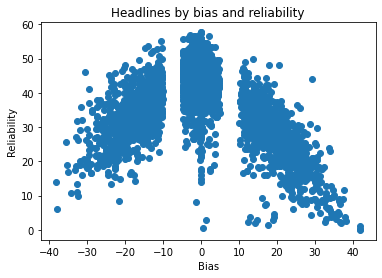

In [70]:
plt.scatter(af_headlines["Bias"], af_headlines["Reliability"])
plt.ylabel('Reliability')
plt.xlabel('Bias')
plt.title('Headlines by bias and reliability')
plt.show()

          

In [71]:
print("Number of headlines that are extreme: ", af_headlines["Headline"][(af_headlines["Bias"] > 10) | (af_headlines["Bias"] < -10)].count())
print("Number of headlines that are central: ", af_headlines["Headline"][(af_headlines["Bias"] < 5) & (af_headlines["Bias"] > -5)].count())
print("Total number of headlines: ", af_headlines["Headline"].count())

Number of headlines that are extreme:  1887
Number of headlines that are central:  2497
Total number of headlines:  4384


#### AdFontes BERT

In [72]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# without distant signal pretraining
val_loss1, val_acc1, val_prec1, val_rec1, val_f11, val_f1_micro1, val_f1_wmacro1 = run_model_5fold(af_headlines, model_name='bert', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss1)
acc_cv = np.mean(val_acc1)
prec_cv = np.mean(val_prec1)
rec_cv = np.mean(val_rec1)
f1_cv = np.mean(val_f11)
f1_micro_cv = np.mean(val_f1_micro1)
f1_wmacro_cv = np.mean(val_f1_wmacro1)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 304ms/step - loss: 0.5700 - val_loss: 0.5321
Epoch 2/10
110/110 [==============================] - 31s 282ms/step - loss: 0.3722 - val_loss: 0.4931
Epoch 3/10
28/28 [==============================] - 2s 80ms/step - loss: 0.4931
### Start fold 2


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 47s 306ms/step - loss: 0.5828 - val_loss: 0.4935
Epoch 2/10
110/110 [==============================] - 31s 284ms/step - loss: 0.3602 - val_loss: 0.4733
Epoch 3/10
28/28 [==============================] - 2s 84ms/step - loss: 0.4733
### Start fold 3


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 48s 307ms/step - loss: 0.5772 - val_loss: 0.4922
Epoch 2/10
28/28 [==============================] - 3s 90ms/step - loss: 0.4922
### Start fold 4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 47s 305ms/step - loss: 0.5609 - val_loss: 0.4818
Epoch 2/10
28/28 [==============================] - 3s 95ms/step - loss: 0.4818
### Start fold 5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 48s 313ms/step - loss: 0.5802 - val_loss: 0.5321
Epoch 2/10
28/28 [==============================] - 3s 95ms/step - loss: 0.5321
5-Fold CV Loss: 0.49450960755348206
5-Fold CV Accuracy: 0.7613988639144447
5-Fold CV Precision: 0.7128969603065951
5-Fold CV Recall: 0.7498519360588326
5-Fold CV F1 Score: 0.7300325607983335
5-Fold CV Micro F1 Score: 0.7613988639144447
5-Fold CV Weighted Macro F1 Score: 0.761843227515876


### AdFontes DistilBERT

In [73]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='distilbert', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
110/110 [==============================] - 24s 158ms/step - loss: 0.5743 - val_loss: 0.5102
Epoch 2/10
28/28 [==============================] - 1s 40ms/step - loss: 0.5102
### Start fold 2


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
110/110 [==============================] - 26s 171ms/step - loss: 0.5634 - val_loss: 0.4875
Epoch 2/10
28/28 [==============================] - 1s 43ms/step - loss: 0.4875
### Start fold 3


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
110/110 [==============================] - 25s 160ms/step - loss: 0.5695 - val_loss: 0.4919
Epoch 2/10
28/28 [==============================] - 1s 46ms/step - loss: 0.4919
### Start fold 4


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
110/110 [==============================] - 25s 158ms/step - loss: 0.5594 - val_loss: 0.4978
Epoch 2/10
28/28 [==============================] - 1s 49ms/step - loss: 0.4978
### Start fold 5


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
110/110 [==============================] - 24s 160ms/step - loss: 0.5484 - val_loss: 0.5443
Epoch 2/10
110/110 [==============================] - 16s 148ms/step - loss: 0.3450 - val_loss: 0.5430
Epoch 3/10
28/28 [==============================] - 1s 49ms/step - loss: 0.5430
5-Fold CV Loss: 0.5060978829860687
5-Fold CV Accuracy: 0.7563859254515445
5-Fold CV Precision: 0.7458631900580611
5-Fold CV Recall: 0.6603118465187431
5-Fold CV F1 Score: 0.6992617401766958
5-Fold CV Micro F1 Score: 0.7563859254515447
5-Fold CV Weighted Macro F1 Score: 0.753744090617929


### AdFontes RoBERTa

In [74]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='roberta', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 322ms/step - loss: 0.5168 - val_loss: 0.4083
Epoch 2/10
110/110 [==============================] - 33s 297ms/step - loss: 0.3968 - val_loss: 0.3862
Epoch 3/10
28/28 [==============================] - 2s 87ms/step - loss: 0.3862
### Start fold 2


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 319ms/step - loss: 0.5275 - val_loss: 0.4457
Epoch 2/10
110/110 [==============================] - 33s 297ms/step - loss: 0.3910 - val_loss: 0.4378
Epoch 3/10
110/110 [==============================] - 33s 297ms/step - loss: 0.2725 - val_loss: 0.4201
Epoch 4/10
28/28 [==============================] - 2s 89ms/step - loss: 0.4201
### Start fold 3


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 50s 329ms/step - loss: 0.5129 - val_loss: 0.4388
Epoch 2/10
110/110 [==============================] - 33s 299ms/step - loss: 0.3808 - val_loss: 0.4172
Epoch 3/10
28/28 [==============================] - 3s 95ms/step - loss: 0.4172
### Start fold 4


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 48s 311ms/step - loss: 0.5256 - val_loss: 0.4366
Epoch 2/10
28/28 [==============================] - 3s 98ms/step - loss: 0.4366
### Start fold 5


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 320ms/step - loss: 0.5076 - val_loss: 0.4787
Epoch 2/10
28/28 [==============================] - 3s 90ms/step - loss: 0.4787
5-Fold CV Loss: 0.4277645587921143
5-Fold CV Accuracy: 0.8093013750696386
5-Fold CV Precision: 0.7473454044598011
5-Fold CV Recall: 0.8420782282851247
5-Fold CV F1 Score: 0.7917720593808089
5-Fold CV Micro F1 Score: 0.8093013750696386
5-Fold CV Weighted Macro F1 Score: 0.8101656992850058


In [75]:
val_loss

[0.38623112440109253,
 0.4201417863368988,
 0.4171997308731079,
 0.4365672767162323,
 0.47868287563323975]

In [76]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='xlnet', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Start fold 1


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 56s 386ms/step - loss: 0.5516 - val_loss: 0.5051
Epoch 2/10
110/110 [==============================] - 40s 367ms/step - loss: 0.4279 - val_loss: 0.4820
Epoch 3/10
28/28 [==============================] - 3s 103ms/step - loss: 0.4820
### Start fold 2


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 56s 389ms/step - loss: 0.5825 - val_loss: 0.5163
Epoch 2/10
110/110 [==============================] - 40s 367ms/step - loss: 0.4693 - val_loss: 0.4845
Epoch 3/10
28/28 [==============================] - 3s 104ms/step - loss: 0.4845
### Start fold 3


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 55s 388ms/step - loss: 0.5749 - val_loss: 0.4802
Epoch 2/10
28/28 [==============================] - 3s 116ms/step - loss: 0.4802
### Start fold 4


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 56s 381ms/step - loss: 0.5677 - val_loss: 0.4846
Epoch 2/10
110/110 [==============================] - 40s 363ms/step - loss: 0.4528 - val_loss: 0.4671
Epoch 3/10
28/28 [==============================] - 3s 119ms/step - loss: 0.4671
### Start fold 5


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 56s 388ms/step - loss: 0.5530 - val_loss: 0.5659
Epoch 2/10
110/110 [==============================] - 41s 369ms/step - loss: 0.4573 - val_loss: 0.5247
Epoch 3/10
28/28 [==============================] - 3s 115ms/step - loss: 0.5247
5-Fold CV Loss: 0.48769731521606446
5-Fold CV Accuracy: 0.7709824380541801
5-Fold CV Precision: 0.7278204512444623
5-Fold CV Recall: 0.7582964927792514
5-Fold CV F1 Score: 0.7386476039148221
5-Fold CV Micro F1 Score: 0.7709824380541801
5-Fold CV Weighted Macro F1 Score: 0.7705696412592824


#### Include Pre-Training

In [77]:
def preprocess(df):
    """convert a pandas dataframe into a tensorflow dataset"""
    target = df.pop('Label')
    sentence = df.pop('Headline')

    #tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased') #uncased
    #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    train_encodings = tokenizer(
                        sentence.tolist(),                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        truncation = True, # cut off at max length of the text that can go to BERT
                        padding = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
    
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings), 
         target.tolist()))
    return dataset

In [78]:
# pandas -> tensorflow
# train-test split
df_train, df_test = train_test_split(df, test_size = 0.10, random_state = 42)


train_distant_dataset = preprocess(df_train)
test_distant_dataset = preprocess(df_test)

# batch and randomize
BUFFER_SIZE = 10000
BATCH_SIZE = 32

train_distant_dataset = train_distant_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_distant_dataset = test_distant_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [79]:
tf.keras.backend.clear_session()

In [80]:
# train entire model with distant signals
#bert = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased") #DistilBert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output
#bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True) # after 3 epochs without improvement, stop training

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
roberta.compile(optimizer=optimizer, loss=roberta.compute_loss)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
history_bert = roberta.fit(train_distant_dataset, epochs=1, validation_data = test_distant_dataset, callbacks=[callback])

242/242 [==============================] - 80s 268ms/step - loss: 0.6564 - val_loss: 0.6325


In [82]:
trained_layer = roberta.get_layer(index=0).get_weights()

roberta.save_weights('./checkpoints/bert_final_checkpoint_news_headlines_USA')

#bert.load_weights('./checkpoints/final_checkpoint_distant_learning')

In [83]:
transfer_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
transfer_model.compile(optimizer=optimizer, loss=transfer_model.compute_loss) 

transfer_model.load_weights('./checkpoints/bert_final_checkpoint_news_headlines_USA')
trained_model_layer = transfer_model.get_layer(index=0).get_weights()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### AdFontes Pre-Trained on AllSides

In [84]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='roberta', 
                                                                                            freeze_encoder=False, pretrained=True)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 54s 326ms/step - loss: 0.5196 - val_loss: 0.4608
Epoch 2/10
110/110 [==============================] - 33s 297ms/step - loss: 0.3944 - val_loss: 0.4374
Epoch 3/10
28/28 [==============================] - 2s 88ms/step - loss: 0.4374
### Start fold 2


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 319ms/step - loss: 0.5217 - val_loss: 0.5442
Epoch 2/10
110/110 [==============================] - 33s 297ms/step - loss: 0.4187 - val_loss: 0.4293
Epoch 3/10
28/28 [==============================] - 3s 90ms/step - loss: 0.4293
### Start fold 3


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 50s 322ms/step - loss: 0.5411 - val_loss: 0.4937
Epoch 2/10
110/110 [==============================] - 33s 299ms/step - loss: 0.4021 - val_loss: 0.4271
Epoch 3/10
28/28 [==============================] - 3s 97ms/step - loss: 0.4271
### Start fold 4


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 312ms/step - loss: 0.5507 - val_loss: 0.5052
Epoch 2/10
28/28 [==============================] - 3s 98ms/step - loss: 0.5052
### Start fold 5


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 50s 321ms/step - loss: 0.5043 - val_loss: 0.4771
Epoch 2/10
28/28 [==============================] - 3s 90ms/step - loss: 0.4771
5-Fold CV Loss: 0.45520569682121276
5-Fold CV Accuracy: 0.7876324435211364
5-Fold CV Precision: 0.7409357355498519
5-Fold CV Recall: 0.7817565576186267
5-Fold CV F1 Score: 0.7573110264794962
5-Fold CV Micro F1 Score: 0.7876324435211364
5-Fold CV Weighted Macro F1 Score: 0.7872267482355559


#### Include Pre-Training

In [85]:
def preprocess(df):
    """convert a pandas dataframe into a tensorflow dataset"""
    target = df.pop('Label')
    sentence = df.pop('Headline')

    #tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased') #uncased
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    #tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    train_encodings = tokenizer(
                        sentence.tolist(),                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        truncation = True, # cut off at max length of the text that can go to BERT
                        padding = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
    
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings), 
         target.tolist()))
    return dataset

In [86]:
# pandas -> tensorflow
# train-test split
df_train, df_test = train_test_split(df, test_size = 0.10, random_state = 42)


train_distant_dataset = preprocess(df_train)
test_distant_dataset = preprocess(df_test)

# batch and randomize
BUFFER_SIZE = 10000
BATCH_SIZE = 32

train_distant_dataset = train_distant_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_distant_dataset = test_distant_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [87]:
tf.keras.backend.clear_session()

In [88]:
# train entire model with distant signals
#bert = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased") #DistilBert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output
bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
##roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True) # after 3 epochs without improvement, stop training

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
bert.compile(optimizer=optimizer, loss=bert.compute_loss)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [89]:
history_bert = bert.fit(train_distant_dataset, epochs=1, validation_data = test_distant_dataset, callbacks=[callback])

242/242 [==============================] - 69s 219ms/step - loss: 0.6993 - val_loss: 0.6933


In [90]:
trained_layer = bert.get_layer(index=0).get_weights()

bert.save_weights('./checkpoints/bert_final_checkpoint_news_headlines_USA')

#bert.load_weights('./checkpoints/final_checkpoint_distant_learning')

In [91]:
transfer_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
transfer_model.compile(optimizer=optimizer, loss=transfer_model.compute_loss) 

transfer_model.load_weights('./checkpoints/bert_final_checkpoint_news_headlines_USA')
trained_model_layer = transfer_model.get_layer(index=0).get_weights()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### AdFontes Pre-Trained on AllSides

In [92]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='bert', 
                                                                                            freeze_encoder=False, pretrained=True)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 53s 311ms/step - loss: 0.6809 - val_loss: 0.5901
Epoch 2/10
110/110 [==============================] - 31s 282ms/step - loss: 0.5801 - val_loss: 0.5632
Epoch 3/10
110/110 [==============================] - 31s 282ms/step - loss: 0.4650 - val_loss: 0.5016
Epoch 4/10
28/28 [==============================] - 2s 84ms/step - loss: 0.5016
### Start fold 2


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 48s 305ms/step - loss: 0.6795 - val_loss: 0.6481
Epoch 2/10
110/110 [==============================] - 31s 284ms/step - loss: 0.5676 - val_loss: 0.5189
Epoch 3/10
110/110 [==============================] - 31s 283ms/step - loss: 0.4061 - val_loss: 0.4970
Epoch 4/10
28/28 [==============================] - 2s 89ms/step - loss: 0.4970
### Start fold 3


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 51s 308ms/step - loss: 0.6877 - val_loss: 0.6874
Epoch 2/10
110/110 [==============================] - 31s 285ms/step - loss: 0.6847 - val_loss: 0.6847
Epoch 3/10
110/110 [==============================] - 31s 285ms/step - loss: 0.6856 - val_loss: 0.6841
Epoch 4/10
110/110 [==============================] - 31s 285ms/step - loss: 0.6870 - val_loss: 0.6837
Epoch 5/10
28/28 [==============================] - 3s 95ms/step - loss: 0.6837


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Start fold 4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 305ms/step - loss: 0.6794 - val_loss: 0.6845
Epoch 2/10
110/110 [==============================] - 31s 283ms/step - loss: 0.6382 - val_loss: 0.5540
Epoch 3/10
28/28 [==============================] - 3s 95ms/step - loss: 0.5540
### Start fold 5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 50s 310ms/step - loss: 0.6865 - val_loss: 0.6856
Epoch 2/10
28/28 [==============================] - 3s 95ms/step - loss: 0.6856
5-Fold CV Loss: 0.584377509355545
5-Fold CV Accuracy: 0.67926331464155
5-Fold CV Precision: 0.4274562211981567
5-Fold CV Recall: 0.437779461917393
5-Fold CV F1 Score: 0.43078191676289135
5-Fold CV Micro F1 Score: 0.67926331464155
5-Fold CV Weighted Macro F1 Score: 0.6165497410885905


#### AdFontes Freeze Encoder

In [93]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='roberta', 
                                                                                            freeze_encoder=True, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 22s 153ms/step - loss: 0.6812 - val_loss: 0.6725
Epoch 2/10
110/110 [==============================] - 14s 130ms/step - loss: 0.6702 - val_loss: 0.6625
Epoch 3/10
110/110 [==============================] - 14s 130ms/step - loss: 0.6531 - val_loss: 0.6463
Epoch 4/10
110/110 [==============================] - 14s 131ms/step - loss: 0.6412 - val_loss: 0.6319
Epoch 5/10
110/110 [==============================] - 15s 135ms/step - loss: 0.6246 - val_loss: 0.6157
Epoch 6/10
110/110 [==============================] - 15s 134ms/step - loss: 0.6115 - val_loss: 0.5991
Epoch 7/10
110/110 [==============================] - 14s 131ms/step - loss: 0.5954 - val_loss: 0.5817
Epoch 8/10
110/110 [==============================] - 14s 130ms/step - loss: 0.5817 - val_loss: 0.5686
Epoch 9/10
110/110 [==============================] - 14s 130ms/step - loss: 0.5724 - val_loss: 0.5530
Epoch 10/10
28/28 [==============================] - 3s 92ms/step - loss:

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 22s 154ms/step - loss: 0.6810 - val_loss: 0.6726
Epoch 2/10
110/110 [==============================] - 14s 131ms/step - loss: 0.6677 - val_loss: 0.6600
Epoch 3/10
110/110 [==============================] - 14s 132ms/step - loss: 0.6528 - val_loss: 0.6464
Epoch 4/10
110/110 [==============================] - 15s 135ms/step - loss: 0.6410 - val_loss: 0.6333
Epoch 5/10
110/110 [==============================] - 15s 136ms/step - loss: 0.6212 - val_loss: 0.6177
Epoch 6/10
110/110 [==============================] - 14s 132ms/step - loss: 0.6085 - val_loss: 0.6015
Epoch 7/10
110/110 [==============================] - 14s 131ms/step - loss: 0.5925 - val_loss: 0.5834
Epoch 8/10
110/110 [==============================] - 14s 131ms/step - loss: 0.5807 - val_loss: 0.5736
Epoch 9/10
110/110 [==============================] - 14s 131ms/step - loss: 0.5676 - val_loss: 0.5580
Epoch 10/10
28/28 [==============================] - 3s 93ms/step - loss:

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 23s 156ms/step - loss: 0.6793 - val_loss: 0.6723
Epoch 2/10
110/110 [==============================] - 15s 133ms/step - loss: 0.6661 - val_loss: 0.6598
Epoch 3/10
110/110 [==============================] - 15s 138ms/step - loss: 0.6500 - val_loss: 0.6464
Epoch 4/10
110/110 [==============================] - 15s 136ms/step - loss: 0.6385 - val_loss: 0.6330
Epoch 5/10
110/110 [==============================] - 15s 134ms/step - loss: 0.6227 - val_loss: 0.6193
Epoch 6/10
110/110 [==============================] - 15s 133ms/step - loss: 0.6103 - val_loss: 0.6029
Epoch 7/10
110/110 [==============================] - 15s 133ms/step - loss: 0.5968 - val_loss: 0.5887
Epoch 8/10
110/110 [==============================] - 15s 134ms/step - loss: 0.5821 - val_loss: 0.5766
Epoch 9/10
110/110 [==============================] - 15s 133ms/step - loss: 0.5699 - val_loss: 0.5697
Epoch 10/10
28/28 [==============================] - 3s 100ms/step - loss

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 22s 154ms/step - loss: 0.6803 - val_loss: 0.6715
Epoch 2/10
110/110 [==============================] - 15s 136ms/step - loss: 0.6641 - val_loss: 0.6582
Epoch 3/10
110/110 [==============================] - 15s 135ms/step - loss: 0.6505 - val_loss: 0.6435
Epoch 4/10
110/110 [==============================] - 14s 131ms/step - loss: 0.6374 - val_loss: 0.6284
Epoch 5/10
110/110 [==============================] - 14s 131ms/step - loss: 0.6221 - val_loss: 0.6123
Epoch 6/10
110/110 [==============================] - 14s 131ms/step - loss: 0.6058 - val_loss: 0.5962
Epoch 7/10
110/110 [==============================] - 14s 131ms/step - loss: 0.5908 - val_loss: 0.5803
Epoch 8/10
110/110 [==============================] - 14s 131ms/step - loss: 0.5741 - val_loss: 0.5660
Epoch 9/10
110/110 [==============================] - 14s 131ms/step - loss: 0.5655 - val_loss: 0.5561
Epoch 10/10
28/28 [==============================] - 3s 104ms/step - loss

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 25s 165ms/step - loss: 0.6800 - val_loss: 0.6731
Epoch 2/10
110/110 [==============================] - 15s 136ms/step - loss: 0.6664 - val_loss: 0.6620
Epoch 3/10
110/110 [==============================] - 15s 133ms/step - loss: 0.6515 - val_loss: 0.6499
Epoch 4/10
110/110 [==============================] - 15s 133ms/step - loss: 0.6375 - val_loss: 0.6398
Epoch 5/10
110/110 [==============================] - 15s 133ms/step - loss: 0.6201 - val_loss: 0.6213
Epoch 6/10
110/110 [==============================] - 15s 133ms/step - loss: 0.6073 - val_loss: 0.6074
Epoch 7/10
110/110 [==============================] - 15s 132ms/step - loss: 0.5872 - val_loss: 0.5935
Epoch 8/10
110/110 [==============================] - 15s 133ms/step - loss: 0.5825 - val_loss: 0.5844
Epoch 9/10
110/110 [==============================] - 15s 133ms/step - loss: 0.5664 - val_loss: 0.5699
Epoch 10/10
28/28 [==============================] - 3s 95ms/step - loss:

#### AdFontes Freeze Encoder + Pre-Trained

In [94]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='bert', 
                                                                                            freeze_encoder=True, pretrained=True)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 23s 154ms/step - loss: 0.6868 - val_loss: 0.6833
Epoch 2/10
28/28 [==============================] - 2s 83ms/step - loss: 0.6833


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Start fold 2


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 22s 159ms/step - loss: 0.6887 - val_loss: 0.6833
Epoch 2/10
28/28 [==============================] - 2s 88ms/step - loss: 0.6833
### Start fold 3


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 22s 151ms/step - loss: 0.6853 - val_loss: 0.6837
Epoch 2/10
28/28 [==============================] - 3s 95ms/step - loss: 0.6837
### Start fold 4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 22s 157ms/step - loss: 0.6883 - val_loss: 0.6845
Epoch 2/10
110/110 [==============================] - 15s 132ms/step - loss: 0.6845 - val_loss: 0.6836
Epoch 3/10
28/28 [==============================] - 3s 99ms/step - loss: 0.6836
### Start fold 5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 22s 152ms/step - loss: 0.6862 - val_loss: 0.6842
Epoch 2/10
110/110 [==============================] - 14s 129ms/step - loss: 0.6861 - val_loss: 0.6834
Epoch 3/10
28/28 [==============================] - 3s 99ms/step - loss: 0.6834
5-Fold CV Loss: 0.683461356163025
5-Fold CV Accuracy: 0.5695711823724507
5-Fold CV Precision: 0.0
5-Fold CV Recall: 0.0
5-Fold CV F1 Score: 0.0
5-Fold CV Micro F1 Score: 0.5695711823724507
5-Fold CV Weighted Macro F1 Score: 0.41337588431512867


#### AdFontes Electra

In [95]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='electra', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 27s 106ms/step - loss: 0.6445 - val_loss: 0.6248
Epoch 2/10
110/110 [==============================] - 9s 84ms/step - loss: 0.5225 - val_loss: 0.5264
Epoch 3/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5264
### Start fold 2


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 27s 112ms/step - loss: 0.6359 - val_loss: 0.5520
Epoch 2/10
110/110 [==============================] - 9s 83ms/step - loss: 0.5213 - val_loss: 0.5266
Epoch 3/10
110/110 [==============================] - 9s 83ms/step - loss: 0.4152 - val_loss: 0.5237
Epoch 4/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5237
### Start fold 3


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 25s 106ms/step - loss: 0.6368 - val_loss: 0.5637
Epoch 2/10
110/110 [==============================] - 9s 83ms/step - loss: 0.5104 - val_loss: 0.5133
Epoch 3/10
110/110 [==============================] - 9s 83ms/step - loss: 0.4208 - val_loss: 0.5103
Epoch 4/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5103
### Start fold 4


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 28s 113ms/step - loss: 0.6489 - val_loss: 0.5631
Epoch 2/10
110/110 [==============================] - 10s 89ms/step - loss: 0.5201 - val_loss: 0.5499
Epoch 3/10
28/28 [==============================] - 1s 37ms/step - loss: 0.5499
### Start fold 5


Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 27s 106ms/step - loss: 0.6284 - val_loss: 0.5914
Epoch 2/10
28/28 [==============================] - 1s 34ms/step - loss: 0.5914
5-Fold CV Loss: 0.5403617143630981
5-Fold CV Accuracy: 0.7310582985791121
5-Fold CV Precision: 0.6996443065618715
5-Fold CV Recall: 0.6773118324842463
5-Fold CV F1 Score: 0.6749822078981118
5-Fold CV Micro F1 Score: 0.7310582985791121
5-Fold CV Weighted Macro F1 Score: 0.7263453766381932


### Ablation Study

Run our best classifier on first a quarter, then half the AllSides data. See how dataset size affects classifier performance. 

In [96]:
df_quart = df.sample(n = round(len(df)*.25), random_state = 1)
df_half = df.sample(n = round(len(df)*.5), random_state = 1)

#### Quarter

In [97]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df_quart, model_name='roberta', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
54/54 [==============================] - 28s 259ms/step - loss: 0.6846 - val_loss: 0.6536
Epoch 2/10
14/14 [==============================] - 1s 73ms/step - loss: 0.6536
### Start fold 2


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
54/54 [==============================] - 30s 262ms/step - loss: 0.6891 - val_loss: 0.6520
Epoch 2/10
54/54 [==============================] - 12s 220ms/step - loss: 0.6696 - val_loss: 0.6427
Epoch 3/10
54/54 [==============================] - 12s 220ms/step - loss: 0.6352 - val_loss: 0.6281
Epoch 4/10
14/14 [==============================] - 1s 67ms/step - loss: 0.6281
### Start fold 3


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
54/54 [==============================] - 29s 283ms/step - loss: 0.6785 - val_loss: 0.6734
Epoch 2/10
14/14 [==============================] - 1s 72ms/step - loss: 0.6734
### Start fold 4


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
54/54 [==============================] - 28s 264ms/step - loss: 0.6794 - val_loss: 0.6666
Epoch 2/10
14/14 [==============================] - 1s 65ms/step - loss: 0.6666
### Start fold 5


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
54/54 [==============================] - 31s 272ms/step - loss: 0.6838 - val_loss: 0.6773
Epoch 2/10
14/14 [==============================] - 1s 70ms/step - loss: 0.6773
5-Fold CV Loss: 0.6597838640213013
5-Fold CV Accuracy: 0.5988715334509727
5-Fold CV Precision: 0.6420553997644973
5-Fold CV Recall: 0.6073614653373521
5-Fold CV F1 Score: 0.6005250209112576
5-Fold CV Micro F1 Score: 0.5988715334509727
5-Fold CV Weighted Macro F1 Score: 0.584707694510526


#### Half

In [98]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(df_half, model_name='roberta', 
                                                                                            freeze_encoder=False, pretrained=False)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
108/108 [==============================] - 45s 291ms/step - loss: 0.6746 - val_loss: 0.6335
Epoch 2/10
108/108 [==============================] - 29s 269ms/step - loss: 0.6191 - val_loss: 0.6041
Epoch 3/10
27/27 [==============================] - 2s 75ms/step - loss: 0.6041
### Start fold 2


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
108/108 [==============================] - 47s 299ms/step - loss: 0.6892 - val_loss: 0.6967
Epoch 2/10
27/27 [==============================] - 2s 74ms/step - loss: 0.6967
### Start fold 3


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
108/108 [==============================] - 47s 291ms/step - loss: 0.6755 - val_loss: 0.6550
Epoch 2/10
27/27 [==============================] - 2s 73ms/step - loss: 0.6550
### Start fold 4


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
108/108 [==============================] - 44s 257ms/step - loss: 0.6716 - val_loss: 0.6343
Epoch 2/10
27/27 [==============================] - 2s 92ms/step - loss: 0.6343
### Start fold 5


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
108/108 [==============================] - 45s 289ms/step - loss: 0.6915 - val_loss: 0.6901
Epoch 2/10
108/108 [==============================] - 29s 266ms/step - loss: 0.6823 - val_loss: 0.6578
Epoch 3/10
27/27 [==============================] - 2s 67ms/step - loss: 0.6578
5-Fold CV Loss: 0.6495730161666871
5-Fold CV Accuracy: 0.5979570410142172
5-Fold CV Precision: 0.7252492885126044
5-Fold CV Recall: 0.4884249417957284
5-Fold CV F1 Score: 0.5012193796715526
5-Fold CV Micro F1 Score: 0.5979570410142172
5-Fold CV Weighted Macro F1 Score: 0.5608214421281478


In [99]:
df_half['Label'].value_counts()

1    2224
0    2064
Name: Label, dtype: int64

### Pre-training on BABE, Running on AdFontes 

In [100]:
def preprocess(df):
    """convert a pandas dataframe into a tensorflow dataset"""
    target = df.pop('Label')
    sentence = df.pop('text')

    #tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased') #uncased
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    #tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    train_encodings = tokenizer(
                        sentence.tolist(),                      
                        add_special_tokens = True, # add [CLS], [SEP]
                        truncation = True, # cut off at max length of the text that can go to BERT
                        padding = True, # add [PAD] tokens
                        return_attention_mask = True, # add attention mask to not focus on pad tokens
              )
    
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(train_encodings), 
         target.tolist()))
    return dataset

In [101]:
# pandas -> tensorflow
# train-test split
df_train, df_test = train_test_split(babe, test_size = 0.10, random_state = 42)


train_distant_dataset = preprocess(df_train)
test_distant_dataset = preprocess(df_test)

# batch and randomize
BUFFER_SIZE = 10000
BATCH_SIZE = 32

train_distant_dataset = train_distant_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_distant_dataset = test_distant_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [102]:
tf.keras.backend.clear_session()

In [103]:
# train entire model with distant signals
#bert = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased") #DistilBert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output
bert = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
##roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True) # after 3 epochs without improvement, stop training

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
bert.compile(optimizer=optimizer, loss=bert.compute_loss)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
history_bert = bert.fit(train_distant_dataset, epochs=1, validation_data = test_distant_dataset, callbacks=[callback])

104/104 [==============================] - 66s 485ms/step - loss: 0.5300 - val_loss: 0.4389


In [105]:
trained_layer = bert.get_layer(index=0).get_weights()

bert.save_weights('./checkpoints/bert_final_checkpoint_news_headlines_USA')

#bert.load_weights('./checkpoints/final_checkpoint_distant_learning')

In [106]:
transfer_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
transfer_model.compile(optimizer=optimizer, loss=transfer_model.compute_loss) 

transfer_model.load_weights('./checkpoints/bert_final_checkpoint_news_headlines_USA')
trained_model_layer = transfer_model.get_layer(index=0).get_weights()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### AdFontes Pre-Trained on AllSides

In [107]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# without distant signal pretraining
val_loss, val_acc, val_prec, val_rec, val_f1, val_f1_micro, val_f1_wmacro = run_model_5fold(af_headlines, model_name='bert', 
                                                                                            freeze_encoder=False, pretrained=True)

# inspect metrics
loss_cv = np.mean(val_loss)
acc_cv = np.mean(val_acc)
prec_cv = np.mean(val_prec)
rec_cv = np.mean(val_rec)
f1_cv = np.mean(val_f1)
f1_micro_cv = np.mean(val_f1_micro)
f1_wmacro_cv = np.mean(val_f1_wmacro)

print('5-Fold CV Loss: {}'.format(loss_cv))
print('5-Fold CV Accuracy: {}'.format(acc_cv))
print('5-Fold CV Precision: {}'.format(prec_cv))
print('5-Fold CV Recall: {}'.format(rec_cv))
print('5-Fold CV F1 Score: {}'.format(f1_cv))
print('5-Fold CV Micro F1 Score: {}'.format(f1_micro_cv))
print('5-Fold CV Weighted Macro F1 Score: {}'.format(f1_wmacro_cv))

### Start fold 1


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 51s 306ms/step - loss: 0.5463 - val_loss: 0.5006
Epoch 2/10
28/28 [==============================] - 2s 81ms/step - loss: 0.5006
### Start fold 2


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 48s 312ms/step - loss: 0.5725 - val_loss: 0.4927
Epoch 2/10
110/110 [==============================] - 32s 290ms/step - loss: 0.3642 - val_loss: 0.4905
Epoch 3/10
28/28 [==============================] - 2s 87ms/step - loss: 0.4905
### Start fold 3


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 47s 308ms/step - loss: 0.5741 - val_loss: 0.4934
Epoch 2/10
28/28 [==============================] - 3s 91ms/step - loss: 0.4934
### Start fold 4


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 52s 308ms/step - loss: 0.5777 - val_loss: 0.4967
Epoch 2/10
110/110 [==============================] - 31s 283ms/step - loss: 0.3736 - val_loss: 0.4878
Epoch 3/10
28/28 [==============================] - 3s 96ms/step - loss: 0.4878
### Start fold 5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
110/110 [==============================] - 49s 311ms/step - loss: 0.5454 - val_loss: 0.5161
Epoch 2/10
28/28 [==============================] - 3s 96ms/step - loss: 0.5161
5-Fold CV Loss: 0.49767595529556274
5-Fold CV Accuracy: 0.76299625643669
5-Fold CV Precision: 0.7352403614430771
5-Fold CV Recall: 0.7058594024111267
5-Fold CV F1 Score: 0.7190110425146969
5-Fold CV Micro F1 Score: 0.76299625643669
5-Fold CV Weighted Macro F1 Score: 0.7620981537110633
